# Control System Design

## Linearização da planta

Para a aplicação de um controle no sistema é necessário a linearização das equações da dinâmica do satélite.

No contexto para pequenos ângulos a linearização se dá pela substituição de sin $\theta$ $\approx$ $\theta$ e cos $\theta$ $\approx$ 1,
tem-se portanto:

$\ddot{\phi}=\frac{1}{J_x}(\omega_o^2(J_z-J_y)\phi+\omega_o(J_x+J_z-J_y) \dot{\psi}+T_x)$

$\ddot{\theta}=\frac{T_y}{J_y}$

$\ddot{\psi}=\frac{1}{J_z}(-\omega_o^2(J_y-J_x)\psi-\omega_o(J_z-J_y+J_x) \dot{\phi}+T_z)$


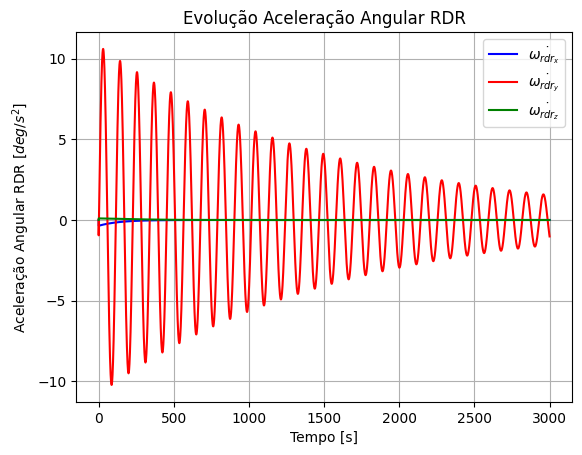

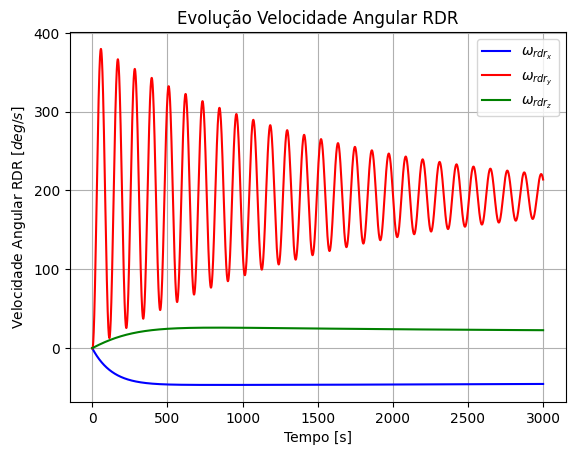

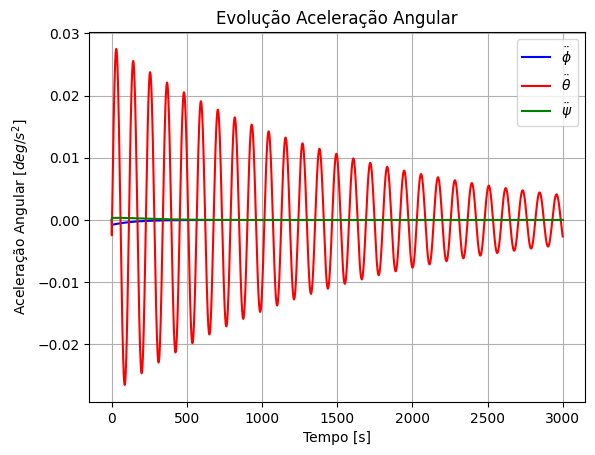

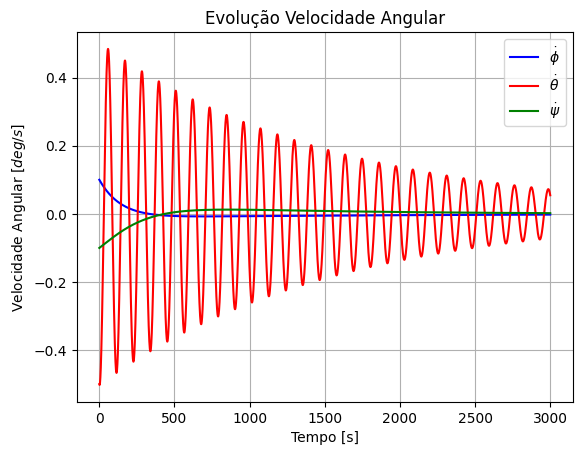

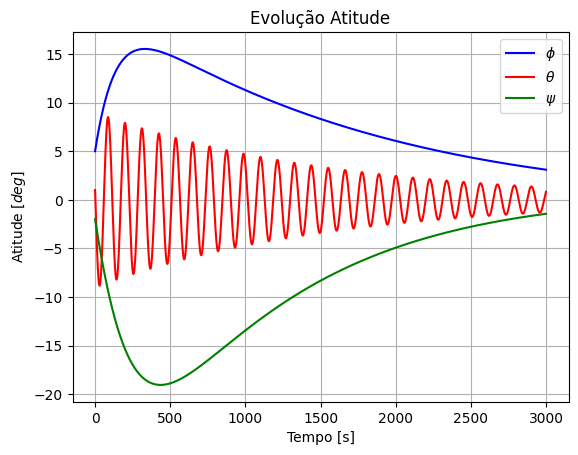

In [7]:
import matplotlib.pyplot as plt
from numpy import pi
import numpy as np

mu_Terra = 3.98600441e+014

def osv2eko(r_SCGI, v_SCGI):
    global mu_Terra
    # versores sistema de coordenadas inercial centrado na terra J2000
    vec_k = np.array([0, 0, 1])
    vec_i = np.array([1, 0, 0])
    # Elementos orbitais clássicos
    h = np.cross(r_SCGI, v_SCGI) # [m**2/s]
    p = np.dot(h, h)/mu_Terra # [m]
    B = np.cross(v_SCGI,h) - mu_Terra * r_SCGI / np.linalg.norm(r_SCGI) # [m^3/s**2]
    e = B/mu_Terra
    a = p/(1-np.dot(e, e)) # [m]
    vec_N = np.cross(vec_k, h) # [m**2/s]
    i = np.arccos(np.dot(vec_k, h)/np.linalg.norm(h))
    RAAN = np.arccos(np.dot(vec_i, vec_N)/np.linalg.norm(vec_N)) # [rad]
    omega = np.arccos(np.dot(e, vec_N)/(np.linalg.norm(e)*np.linalg.norm(vec_N))) # [rad]
    f = np.real(np.arccos(np.dot(r_SCGI, e)/(np.linalg.norm(e)*np.linalg.norm(r_SCGI)))) # [rad]
    return  [a, e, i, RAAN, omega, f]


r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006]) # m
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003]) # m/s
[a, e, i, RAAN, omega, f] = osv2eko(r_SCGI, v_SCGI)


movimentoMedio = np.sqrt(mu_Terra/a**3) # [rad/s]
w_O_I_O = movimentoMedio

samples = 100000
dt = 0.03
time = np.zeros((samples, 1))
phi = np.zeros((samples, 1))
theta = np.zeros((samples, 1))
psi = np.zeros((samples, 1))
dotphi = np.zeros((samples, 1))
dottheta = np.zeros((samples, 1))
dotpsi = np.zeros((samples, 1))
ddotphi = np.zeros((samples, 1))
ddottheta = np.zeros((samples, 1))
ddotpsi = np.zeros((samples, 1))
w_rdr_x = np.zeros((samples, 1))
w_rdr_y = np.zeros((samples, 1))
w_rdr_z = np.zeros((samples, 1))
dotw_rdr_x = np.zeros((samples, 1))
dotw_rdr_y = np.zeros((samples, 1))
dotw_rdr_z = np.zeros((samples, 1))
T_x = np.zeros((samples, 1))
T_y = np.zeros((samples, 1))
T_z = np.zeros((samples, 1))

phi[0] = np.deg2rad(5)
theta[0] = np.deg2rad(1)
psi[0] = np.deg2rad(-2)

dotphi[0] = np.deg2rad(0.1)
dottheta[0] = np.deg2rad(-0.5)
dotpsi[0] = np.deg2rad(-0.1)

# For a CubeSat 6U
cubeSatMass = 6 #  [kg] 
cubeSatLength = 0.1 # [m] -> x
cubeSatWidth = 0.2 # [m] -> y
cubeSatHeight = 0.3 # [m] -> z

Ixx = 1 /12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Iyy = 1 / 12 * cubeSatMass * ((cubeSatLength ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Izz = 1 / 12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatLength ** 2)) # slug * ft ^ 2

# For a RDR
m_rdr = 0.137 # [kg]
r_rdr = 0.0435 # [m]
I_rdr = 0.5*m_rdr*r_rdr**2 # [kg*m²]
wRDR_max = 8000/9.5492965964254 # [rad/s]

#[[ 2.34836293e-03 -3.43392593e-04  3.69386652e+00  2.30815220e-01]
# [ 1.09354336e-04  9.51070684e-04 -2.66493008e-01  1.23500323e+00]]



K_phi_rdr_x =       -2.34836293e-03
K_psi_rdr_x =       -3.43392593e-04  
K_dotphi_rdr_x =    -3.69386652e+00
K_dotpsi_rdr_x =    -2.30815220e-01
K_phi_rdr_z =       -1.09354336e-04  
K_psi_rdr_z =       -9.51070684e-04
K_dotphi_rdr_z =    -2.66493008e-01
K_dotpsi_rdr_z =    -1.23500323e+00

K_theta = -1.2
K_dottheta = -0.5

for i in range(len(time)-1):
    time[i+1] = time[i]+dt 

    # Controle

    dotw_rdr_x[i+1] = K_phi_rdr_x*phi[i]+K_psi_rdr_x*psi[i]+K_dotphi_rdr_x*dotphi[i]+K_dotpsi_rdr_x*dotpsi[i]
    dotw_rdr_y[i+1] = K_theta*theta[i]+K_dottheta*dottheta[i]   
    dotw_rdr_z[i+1] = K_phi_rdr_z*phi[i]+K_psi_rdr_z*psi[i]+K_dotphi_rdr_z*dotphi[i]+K_dotpsi_rdr_z*dotpsi[i]  
    

    w_rdr_x[i+1] = w_rdr_x[i]+dotw_rdr_x[i+1]*dt
    w_rdr_y[i+1] = w_rdr_y[i]+dotw_rdr_y[i+1]*dt     
    w_rdr_z[i+1] = w_rdr_z[i]+dotw_rdr_z[i+1]*dt

    if abs(w_rdr_x[i+1])>wRDR_max:
        w_rdr_x[i+1] = np.sign(w_rdr_x[i+1])*wRDR_max

    if abs(w_rdr_y[i+1])>wRDR_max:
        w_rdr_y[i+1] = np.sign(w_rdr_x[i+1])*wRDR_max

    if abs(w_rdr_z[i+1])>wRDR_max:
        w_rdr_z[i+1] = np.sign(w_rdr_z[i+1])*wRDR_max

    T_x[i+1] = T_x[i+1]+dotw_rdr_x[i+1]*I_rdr-f*w_rdr_x[i+1] 
    T_y[i+1] = T_y[i+1]+dotw_rdr_y[i+1]*I_rdr-f*w_rdr_y[i+1] 
    T_z[i+1] = T_z[i+1]+dotw_rdr_z[i+1]*I_rdr-f*w_rdr_z[i+1] 

    # Planta
    ddotphi[i+1] = 1/Ixx*(w_O_I_O**2*(Izz-Iyy)*phi[i]+w_O_I_O*(Ixx+Izz-Iyy)*dotpsi[i]+T_x[i+1])
    ddottheta[i+1] = 1/Iyy*T_y[i+1]
    ddotpsi[i+1] = 1/Izz*(-w_O_I_O**2*(Iyy-Ixx)*psi[i]-w_O_I_O*(Izz-Iyy+Ixx)*dotphi[i]+T_z[i+1])

    dotphi[i+1] = dotphi[i]+ddotphi[i+1]*dt
    dottheta[i+1] = dottheta[i]+ddottheta[i+1]*dt
    dotpsi[i+1] = dotpsi[i]+ddotpsi[i+1]*dt

    phi[i+1] =   phi[i]+dotphi[i+1]*dt
    theta[i+1] = theta[i]+dottheta[i+1]*dt
    psi[i+1] =   psi[i]+dotpsi[i+1]*dt 


plt.figure()
plt.title('Evolução Aceleração Angular RDR')
plt.plot(time,np.rad2deg(dotw_rdr_x),'b',label=r'$\dot{\omega_{rdr_x}}$')
plt.plot(time,np.rad2deg(dotw_rdr_y),'r',label=r'$\dot{\omega_{rdr_y}}$')
plt.plot(time,np.rad2deg(dotw_rdr_z),'g',label=r'$\dot{\omega_{rdr_z}}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular RDR [$deg/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular RDR')
plt.plot(time,np.rad2deg(w_rdr_x),'b',label=r'$\omega_{rdr_x}$')
plt.plot(time,np.rad2deg(w_rdr_y),'r',label=r'$\omega_{rdr_y}$')
plt.plot(time,np.rad2deg(w_rdr_z),'g',label=r'$\omega_{rdr_z}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular RDR [$deg/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)


# Resultado Torque por Velocidade de Rotação
plt.figure()
plt.title('Evolução Aceleração Angular')
plt.plot(time,np.rad2deg(ddotphi),'b',label=r'$\ddot{\phi}$')
plt.plot(time,np.rad2deg(ddottheta),'r',label=r'$\ddot{\theta}$')
plt.plot(time,np.rad2deg(ddotpsi),'g',label=r'$\ddot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Aceleração Angular [$deg/s^2$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Velocidade Angular')
plt.plot(time,np.rad2deg(dotphi),'b',label=r'$\dot{\phi}$')
plt.plot(time,np.rad2deg(dottheta),'r',label=r'$\dot{\theta}$')
plt.plot(time,np.rad2deg(dotpsi),'g',label=r'$\dot{\psi}$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Velocidade Angular [$deg/s$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.legend()
plt.grid(True)

plt.figure()
plt.title('Evolução Atitude')
plt.plot(time,np.rad2deg(phi),'b',label=r'$\phi$')
plt.plot(time,np.rad2deg(theta),'r',label=r'$\theta$')
plt.plot(time,np.rad2deg(psi),'g',label=r'$\psi$')
# Configurar os rótulos dos eixos
plt.xlabel(r"Tempo [s]")
plt.ylabel(r"Atitude [$deg$]")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)
plt.legend()


plt.show()

### Em espaço de estados teria-se:

- Meu vetor de estados é:

$X = [\phi, \: \theta, \: \psi, \: \dot{\phi}, \: \dot{\theta}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\theta}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\theta}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:,\dot{\omega_{rdr_y}} \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x)) & 0 & 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\frac{1}{J_{rdr}} & 0 & 0 \\
0 & \frac{1}{J_{rdr}} & 0 \\
0 & 0 & \frac{1}{J_{rdr}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

Perceba que olhando para a matriz A tem-se que o comportamento de $\theta$, $\dot{\theta}$ e $\omega_{{rdr}_y}$ é separado do resto do sistema
assim pode-se separar o estudo em um MIMO e um SISO:
- MIMO -> comportamento de $\phi$ $\psi$, $\dot{\phi}$ $\dot{\psi}$ e $\omega_{{rdr}_x}$ $\omega_{{rdr}_z}$ que são acoplados
- SISO -> comportamento de $\theta$, $\dot{\theta}$ e $\omega_{{rdr}_y}$

### MIMO:


- Meu vetor de estados é:

$X = [\phi, \: \psi, \: \dot{\phi}, \: \dot{\psi}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\phi}, \: \dot{\psi}, \: \ddot{\phi}, \: \ddot{\psi}]^T$

- Meu vetor de controle:

$U = [\dot{\omega_{rdr_x}}, \:, \:, \dot{\omega_{rdr_z}}]^T$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\frac{1}{J_x}*(\omega_o^2(J_z-J_y)) & 0 & 0 & \frac{1}{J_x}*(\omega_o(J_x+J_z-J_y)) \\
0 & \frac{1}{J_z}*(-\omega_o^2(J_y-J_x)) & \frac{1}{J_z}*(-\omega_o(J_z-J_y+J_x))& 0
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
\frac{J_{rdr}}{J_{xx}} & 0 \\
0 & \frac{J_{rdr}}{J_{zz}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$

### SISO:


- Meu vetor de estados é:

$X = [\theta, \: \dot{\theta}]^T$

- Por sua vez a derivada do meu vetor de estados fica:

$\dot{X} = [\dot{\theta}, \: \ddot{\theta}]^T$

- Meu vetor de controle:

$U = \dot{\omega_{rdr_y}}$

Sendo a equação fundamental:

$
A = \begin{bmatrix}
1 & 0 \\
0 & 1 \\
\end{bmatrix}
$

$
B = \begin{bmatrix}
0 & 0 \\
0 & \frac{J_{rdr}}{J_{yy}} \\
\end{bmatrix}
$

$\dot{X} = A\:X+B\:U$